In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [11]:
merged_data = transactions.merge(customers, on="CustomerID")


In [12]:
customer_profile = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
}).reset_index()

In [13]:
customer_profile = customer_profile.merge(customers[["CustomerID", "Region"]], on="CustomerID")

In [14]:
region_dummies = pd.get_dummies(customer_profile["Region"], prefix="Region", drop_first=True)
customer_profile = pd.concat([customer_profile.drop("Region", axis=1), region_dummies], axis=1)

In [15]:
print("Data prepared for clustering.")

Data prepared for clustering.


In [16]:
scaler = StandardScaler()
numerical_features = customer_profile.drop(["CustomerID"], axis=1).values
scaled_features = scaler.fit_transform(numerical_features)

print("Features standardized.")


Features standardized.


In [17]:
best_k = None
best_db_index = float("inf")
best_model = None

db_indices = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_indices.append(db_index)

    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_model = kmeans

print(f"Optimal number of clusters: {best_k}, DB Index: {best_db_index:.4f}")

Optimal number of clusters: 9, DB Index: 0.6146


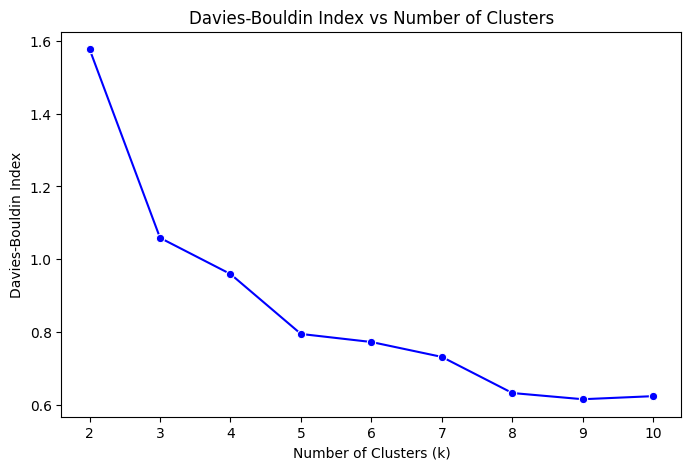

In [18]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=cluster_range, y=db_indices, marker="o", color="blue")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(cluster_range)
plt.show()


In [19]:
customer_profile["Cluster"] = best_model.labels_

customer_profile.to_csv("Customer_Clusters.csv", index=False)

print("Clustered customer data saved to Customer_Clusters.csv.")


Clustered customer data saved to Customer_Clusters.csv.


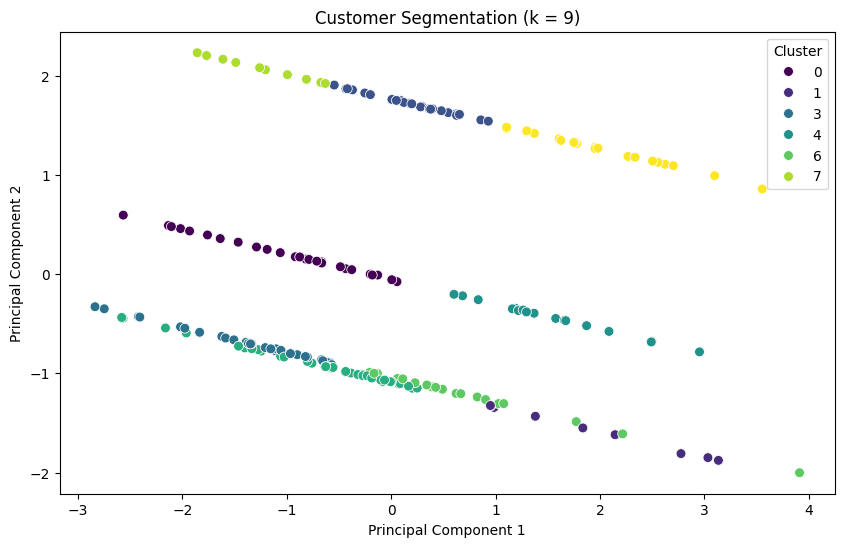

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

clustered_data = pd.DataFrame(reduced_features, columns=["PC1", "PC2"])
clustered_data["Cluster"] = best_model.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_data, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=50)
plt.title(f"Customer Segmentation (k = {best_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()
